<a href="https://colab.research.google.com/github/nikshrimali/TSAI_END2_Phase1/blob/main/qna_BERT_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Reading and data and display sample

import pandas as pd
import os
import torch
from transformers import BertTokenizer, BertModel
import time
import json
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm, trange
import numpy as np

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f'device is {device}')


device is cuda


In [ ]:
def seed_all(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_all()

In [ ]:
# Reading the data

df_data = pd.read_csv('/content/drive/MyDrive/Chatbot_model/final_pd.csv')

In [ ]:
display(df_data)

,Unnamed: 0,question,answer,context
0,0,In what platform do the key nn modules run?,FP32,torch.nn.intrinsic.qat This module implements ...
1,1,What module implements versions of the key nn ...,torch.nn.quantized,This module implements the functions you call ...
2,2,What is needed for quantization aware training?,fused operations,This module implements the versions of those f...
3,3,Conv2d and Linear() use rounding to simulate t...,INT8 quantization,This module implements the versions of those f...
4,4,What module implements versions of the key nn ...,torch.nn.quantized,This module implements the functions you call ...
...,...,...,...,...
25060,95,ptorch geometric has multiple gpu support?,PyTorch Geometric (PyG) is a geometric deep l...,PyTorch Geometric (PyG) is a geometric deep le...
25061,96,Is ptorch geometric compatible with many GPUs?,PyTorch Geometric (PyG) is a geometric deep l...,PyTorch Geometric (PyG) is a geometric deep le...
25062,97,are multiple gpus compatible with pytorch geom...,PyTorch Geometric (PyG) is a geometric deep l...,PyTorch Geometric (PyG) is a geometric deep le...
25063,98,multiple gpus compatible with pytorch geometric?,PyTorch Geometric (PyG) is a geometric deep l...,PyTorch Geometric (PyG) is a geometric deep le...


In [ ]:
import torch

class TextTokenizer(torch.utils.data.Dataset):
    def __init__(
        self,
        data:pd.DataFrame, 
        tokenizer:BertTokenizer,
        source_max_length: int=30,
        ):
        self.tokenizer = tokenizer
        self.data = data
        self.source_max_length = source_max_length



    def __len__(self):
        return len(self.data)


    def __getitem__(self, index:int):
        data_row = self.data.iloc[index]
        question_encoding = tokenizer(
            data_row['question'],
            max_length=self.source_max_length,
            padding='max_length',
            return_attention_mask=True,
            add_special_tokens=True,
            truncation=True,
            return_tensors="pt")
        
        context_encoding = tokenizer(
            data_row['context'],
            max_length=300,
            padding='max_length',
            return_attention_mask=True,
            add_special_tokens=True,
            truncation=True,
            return_tensors="pt")


        return dict(
            input_ids_questions = question_encoding['input_ids'].flatten(),
            attention_mask_questions = question_encoding['attention_mask'].flatten(),
            input_ids_context = context_encoding['input_ids'].flatten(),
            attention_mask_context = context_encoding['attention_mask'].flatten()
        )

In [ ]:
df_train, df_val = train_test_split(df_data, test_size=0.10)

In [ ]:
train_dataset = TextTokenizer(df_train, tokenizer)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8)

In [ ]:
val_dataset = TextTokenizer(df_val, tokenizer)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8)

# Model - BERT-Pretrained

In [ ]:
class Question_Model(torch.nn.Module):
    def __init__(self):
        super(Question_Model, self).__init__()
        self.question_model = BertModel.from_pretrained('bert-base-uncased')
    
    def forward(self, input_ids, attention_mask):
        question_outputs = self.question_model(input_ids, attention_mask)
        return question_outputs


class Context_Model(torch.nn.Module):
    def __init__(self):
        super(Context_Model, self).__init__()
        self.context_model = BertModel.from_pretrained('bert-base-uncased')
    
    def forward(self, input_ids, attention_mask):
        context_outputs = self.context_model(input_ids, attention_mask)
        return context_outputs


class EnsembleTokens(torch.nn.Module):
    def __init__(self):
        super(EnsembleTokens, self).__init__()
        self.question_model = Question_Model().to(device)
        self.context_model = Context_Model().to(device)

        # Freezing context model's params
        for param in list(self.context_model.children()):
            param.requires_grad = False

    
    def forward(self, encoding, mode='train'):

        if mode == 'train':
            question_encoded = self.question_model(encoding['input_ids_questions'].to(device), encoding['attention_mask_questions'].to(device))
            context_encoded = self.context_model(encoding['input_ids_context'].to(device), encoding['attention_mask_context'].to(device))
            return question_encoded, context_encoded

        if mode == 'inference':
            question_encoded = self.question_model(encoding['input_ids_questions'].to(device), encoding['attention_mask_questions'].to(device))
            return question_encoded


In [ ]:
model = EnsembleTokens().to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predicti

In [ ]:
from torch.optim import AdamW

criterion = torch.nn.CosineSimilarity()

learning_rate = 5e-5
adam_epsilon=1e-8
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)

In [ ]:
import glob
checkpoints = sorted(glob.glob('/content/drive/MyDrive/END2_CAPSTONE/qna_checkpoint*-[0-9]*'))

In [ ]:
checkpoints

['/content/drive/MyDrive/END2_CAPSTONE/qna_checkpoint-1000',
 '/content/drive/MyDrive/END2_CAPSTONE/qna_checkpoint-20',
 '/content/drive/MyDrive/END2_CAPSTONE/qna_checkpoint-30',
 '/content/drive/MyDrive/END2_CAPSTONE/qna_checkpoint-40',
 '/content/drive/MyDrive/END2_CAPSTONE/qna_checkpoint-50']

In [ ]:
model = EnsembleTokens().to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predicti

In [ ]:
def to_list(tensor):
    return tensor.detach().cpu().tolist()

In [ ]:
MODEL_STORE = '/content/drive/MyDrive/END2_CAPSTONE'

if len(checkpoints) > 0:
    global_step = int(checkpoints[0].split('-')[-1])
    ckpt_name = 'qna_checkpoint-{}'.format(global_step)
    print("Loading model from checkpoint %s" % ckpt_name)
    
    PATH = f'{MODEL_STORE}/{ckpt_name}/qna_checkpoint-{str(global_step-1)}.pt'
    loss_path = MODEL_STORE + '/'+ ckpt_name + '/training_loss.pt'
    model.load_state_dict(torch.load(PATH)) 
    train_loss_set_ckpt = torch.load(loss_path)
    train_loss_set = to_list(train_loss_set_ckpt)
    tr_loss = train_loss_set[-1]
else:
    global_step = 0
    train_loss_set = []
    tr_loss = 0.0
    model = EnsembleTokens().to(device)

Loading model from checkpoint qna_checkpoint-1000


In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
output_dir = '/content/drive/MyDrive/Chatbot_model'
num_train_epochs = 10
fraction_per_epoch = 0.2

print("***** Running training *****")
print("  Num examples = %d" % len(train_loader))
print("  Num Epochs = %d" % num_train_epochs)
# print("  Batch size = %d" % BATCH_SIZE)
print("  Total optimization steps = %d" % (len(train_loader) // (num_train_epochs * fraction_per_epoch)))
MODEL_STORE = '/content/drive/MyDrive/END2_CAPSTONE'

model.zero_grad()
train_iterator = trange(num_train_epochs, desc="Epoch")

train_loss_set = []
loss = 0
for _ in train_iterator:
    epoch_iterator = tqdm(iter(train_loader), desc="Iteration")
    for step, batch in enumerate(epoch_iterator):
        try:

            model.train()
            question_encoding, context_encoding = model(batch)

            hidden_state_question = question_encoding[0]
            cls_question_output = hidden_state_question[:, 0] 

            hidden_state_context = context_encoding[0]
            cls_context_output = hidden_state_context[:, 0] 
            loss = (1. - criterion(cls_question_output, cls_context_output))

            train_loss_set.append(loss.mean().item())
        #   print(loss, loss.shape)
            loss.mean().backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            tr_loss += loss.mean().item()
            optimizer.step()
            model.zero_grad()
            ckpt_name = 'qna_checkpoint-{}'.format(global_step)
            global_step += 1

        
            if global_step % 1000 == 0:
                print("Train loss: {}".format(tr_loss/global_step))
                output_dir = os.path.join(MODEL_STORE,'qna_checkpoint-{}'.format(global_step))
                PATH = f'{output_dir}/{ckpt_name}.pt'
                loss_path = f'{output_dir}/training_loss.pt'
                if not os.path.exists(output_dir):
                    os.makedirs(output_dir)
                model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training

                torch.save(model_to_save.state_dict(), PATH)
                torch.save(torch.tensor(train_loss_set),loss_path)
                print("Saving model checkpoint to %s" % output_dir)
        except Exception as e:
            print(e)
            continue

***** Running training *****
  Num examples = 2820
  Num Epochs = 10
  Total optimization steps = 1410


Iteration:  33%|███▎      | 921/2820 [16:02<33:28,  1.06s/it]

Train loss: 0.26337431125715377



Iteration:  33%|███▎      | 922/2820 [16:07<1:14:40,  2.36s/it]

Saving model checkpoint to /content/drive/MyDrive/END2_CAPSTONE/qna_checkpoint-4000



Epoch:   0%|          | 0/10 [18:00<?, ?it/s]


ValueError: ignored

In [ ]:
os.path.join(MODEL_STORE,'checkpoint-{}'.format(global_step))

In [ ]:
(1. - criterion(cls_question_output, cls_context_output).mean()).item()

In [ ]:
def inference():
    print("***** Running evaluation *****")
    print("  Num examples = %d" % len(dataset))
    print("  Batch size = %d" % batch_size)
    all_results = []
    predict_file = 'squad/data/dev-v2.0.json'
    for batch in tqdm(val_loader, desc="Evaluating", miniters=100, mininterval=5.0):
        model.eval()
        with torch.no_grad():

            example_indices = batch[3]
            outputs = model(**inputs)

        for i, example_index in enumerate(example_indices):
            eval_feature = features[example_index.item()]
            unique_id = int(eval_feature.unique_id)

            result = RawResult(unique_id    = unique_id,
                            start_logits = to_list(outputs[0][i]),
                            end_logits   = to_list(outputs[1][i]))
            all_results.append(result)

In [4]:
import torch
a = torch.load('../models_store/checkpoint-3100/training_loss.pt')

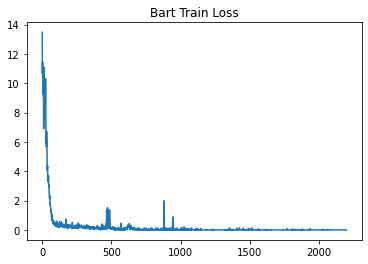

In [9]:
import matplotlib.pyplot as plt
plt.title('Bart Train Loss')
plt.plot(a.tolist())